# 🏥 Epileptic Seizure Recognition

## 🚿 Data import and cleaning

In [ ]:
import pandas as pd

# Loading
data = pd.read_csv('../../Dataset/data.csv')

# Removing first column (not useful)
data.drop('Unnamed', axis=1, inplace=True)

## 👀 Data Observation

### y diffences

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
    
n = 3
data_y_1 = data[data['y'] == 1][:n]
data_y_2 = data[data['y'] == 2][:n]
data_y_3 = data[data['y'] == 3][:n]
data_y_4 = data[data['y'] == 4][:n]
data_y_5 = data[data['y'] == 5][:n]
samples_to_show = pd.concat([data_y_1, data_y_2, data_y_3, data_y_4, data_y_5], axis=0, ignore_index=True)

# Creating a dataframe with one row for each value of X
df_splitted_seizure_short = (samples_to_show
                .melt(id_vars=['y'], var_name='time_label', value_name='EEG', ignore_index=False)
                .reset_index()
                .rename(columns={'index': 'id'})
            )

# Getting time_index column from time_label
df_splitted_seizure_short['time_label'] = (df_splitted_seizure_short['time_label'].str.translate(str.maketrans('', '', 'X')).astype(int))

# Creating and showing the graph
g = sns.relplot(
    palette=sns.color_palette(n_colors=15),
    data=df_splitted_seizure_short,
    kind='line',
    x='time_label',
    y='EEG',
    col='y'
)
g.fig.subplots_adjust(top=.9, left=.07)
g.fig.suptitle("y differences")
g.fig.set_size_inches(13, 5)
plt.legend([], [], frameon=False)
plt.show()

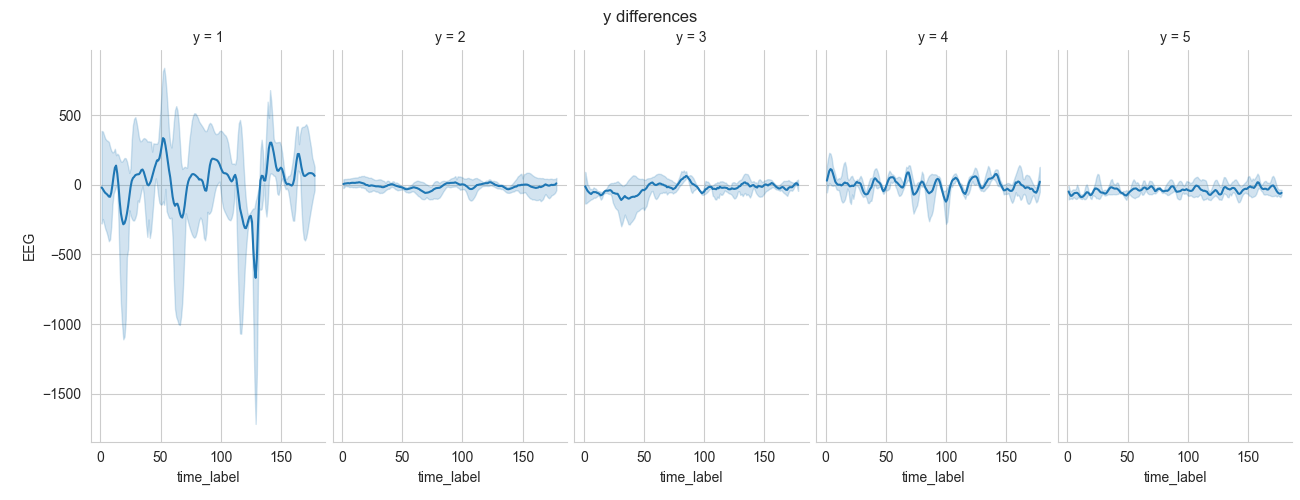

### y numbers

In [ ]:
# Checking the number of rows for each value of y
data_y_1 = data[data['y'] == 1]
data_y_2 = data[data['y'] == 2]
data_y_3 = data[data['y'] == 3]
data_y_4 = data[data['y'] == 4]
data_y_5 = data[data['y'] == 5]


labels = 'y = 1', 'y = 2', 'y = 3', 'y = 4', 'y = 5'
sizes = [len(data_y_1.index), len(data_y_2.index), len(data_y_3.index), len(data_y_4.index), len(data_y_5.index)]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
fig.suptitle("Number of rows for each value of y")
plt.show()

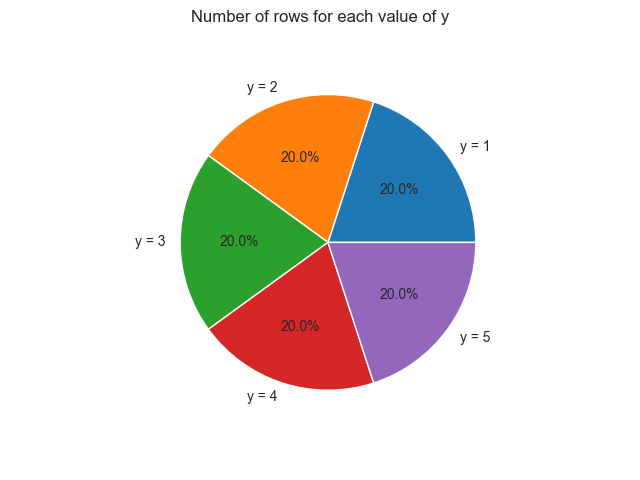

## 📉 Exploratory Data Analysis: examples

### Heatmap

In [ ]:
import seaborn as sns
import numpy as np

data['y'] = np.where(data['y'] == 1, 1, 0)
data['y'] = np.where(data['y'] == 1, 'Epileptic', 'Non-epileptic')
dataframe = (data
                .melt(id_vars=['y'], var_name='time_label', value_name='EEG', ignore_index=False)
                .reset_index()
                .rename(columns={'index': 'id'})
            )
dataframe['time_label'] = (dataframe['time_label'].str.translate(str.maketrans('', '', 'X')).astype(int))

dataframe['y'] = np.where(dataframe['y'] == 'Epileptic', 1, 0)
sns.heatmap(dataframe.corr())
plt.title("Heatmap")
plt.show()

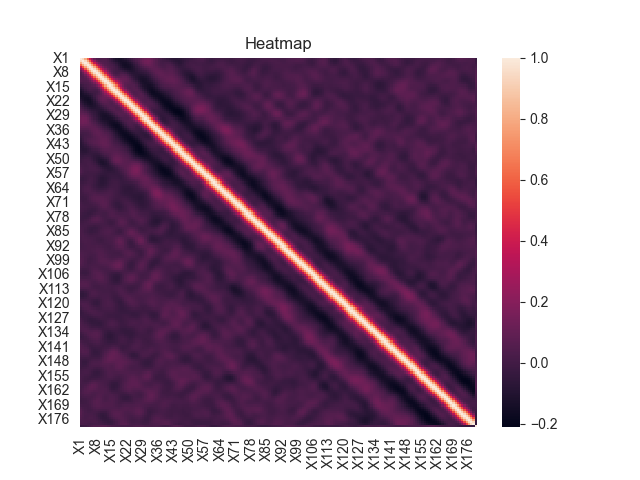

### Box plot

In [ ]:
sns.catplot(
    data=dataframe.groupby(["id", "y"]).std().reset_index(),
    kind='box',
    x='y',
    y='EEG',
).fig.suptitle("Standard deviation")
plt.show()

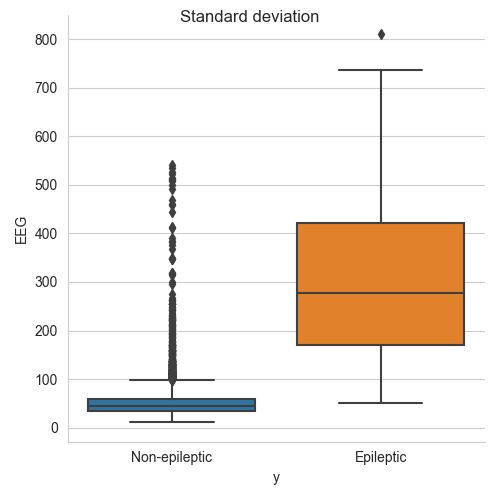

### Kernel Density Estimate

In [ ]:
sns.displot(
    data=dataframe.groupby(["id", "y"]).std().reset_index(),
    kind='kde',
    x='EEG',
    hue='y'
).fig.suptitle("Kernel Density Estimate")
plt.show()

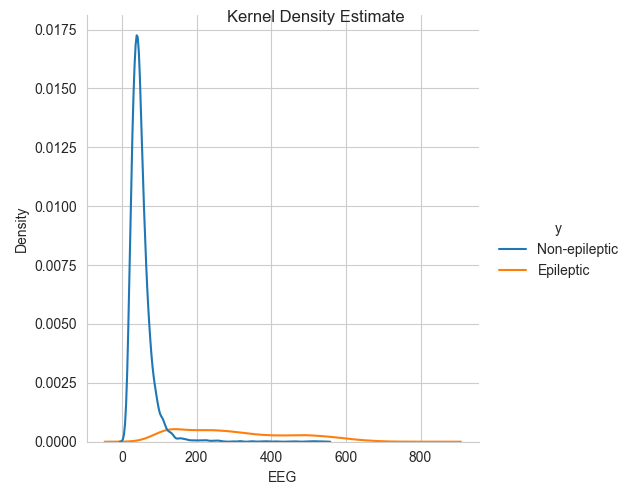

### EEG Altitude

In [ ]:
altitude = data.iloc[:, 0:177]

altitude['extreme_min'] = data.min(axis=1, numeric_only=True)
altitude['extreme_max'] = data.max(axis=1, numeric_only=True)

df_min_max = (altitude.melt(id_vars=['id', 'y'], var_name='min_or_max', value_name='min_max_value', ignore_index=False))
ret = sns.relplot(
    data=df_min_max,
    x='id',
    y='min_max_value',
    col='y',
    hue='min_or_max',
    style='min_or_max',
    edgecolor='#CCFFFF'
)
ret.set_xlabels("Heartbeat recording", clear_inner=False)
ret.set_ylabels('Extreme min/max altitude' + " value", clear_inner=False)
ret.fig.subplots_adjust(top=.9)
ret.fig.suptitle("Extreme min/max altitude value for each heartbeat recording")
ret.set(xticklabels=[])

axes = ret.axes.flat[0]
axes.axhline(df_min_max[(df_min_max['y'] == 'Non-epileptic') & (df_min_max['min_or_max'] == 'min')]['min_max_value'].mean(), ls='--', linewidth=2, color='red')

axes = ret.axes.flat[1]
axes.axhline(df_min_max[(df_min_max['y'] == 'Epileptic') & (df_min_max['min_or_max'] == 'min')]['min_max_value'].mean(), ls='--', linewidth=2, color='red')

axes = ret.axes.flat[0]
axes.axhline(df_min_max[(df_min_max['y'] == 'Non-epileptic') & (df_min_max['min_or_max'] == 'max')]['min_max_value'].mean(), ls='--', linewidth=2, color='red')

axes = ret.axes.flat[1]
axes.axhline(df_min_max[(df_min_max['y'] == 'Epileptic') & (df_min_max['min_or_max'] == 'max')]['min_max_value'].mean(), ls='--', linewidth=2, color='red')

plt.show()

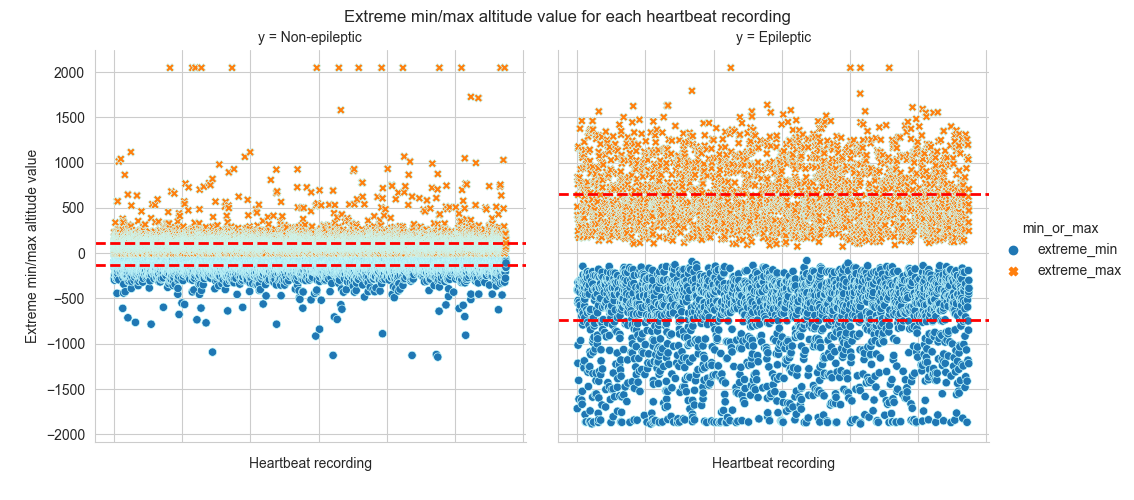

## Ⓜ️ Machine Learning Algorithms: example with Neural Network

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# dividing EEG data and epileptic/non-epileptic typology
X = data.iloc[:,0:178].values
y = data.iloc[:,178].values

# dividing in training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score, jaccard_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



#################################
####### Training and Test #######
#################################
#preparing
grid = {
    'hidden_layer_sizes': [(20,), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd'],
    'alpha': [0.0001, 0.05],
    'max_iter': [1000]
}
cross_val = GridSearchCV(MLPClassifier(), grid, cv = 7, n_jobs=2, verbose=10)

# training
cross_val.fit(X_train, y_train)

# test
Y_hat_test = cross_val.predict(X_test)

# printing results
print('Tuned hpyerparameters (best parameters): ', cross_val.best_params_)
print('Estimator that was chosen by the search: ', cross_val.best_estimator_)
print('Model classification report with GridSearcg CV: \n', classification_report(y_test, Y_hat_test))


In [ ]:
#################################
########## Evaluation ###########
#################################
print("Accuracy score on the test set: ", accuracy_score(y_test, Y_hat_test))
print("F1 score on the test set: ", f1_score(y_test, Y_hat_test))
print("Cohen Kappa Score on the test set: ", cohen_kappa_score(y_test, Y_hat_test))
print("Jaccard Score on the test set: ", jaccard_score(y_test, Y_hat_test))
print("Precision Score on the test set: ", precision_score(y_test, Y_hat_test))
print("Recall Score on the test set: ", recall_score(y_test, Y_hat_test))
print("Balanced Accuracy Score on the test set: ", balanced_accuracy_score(y_test, Y_hat_test))

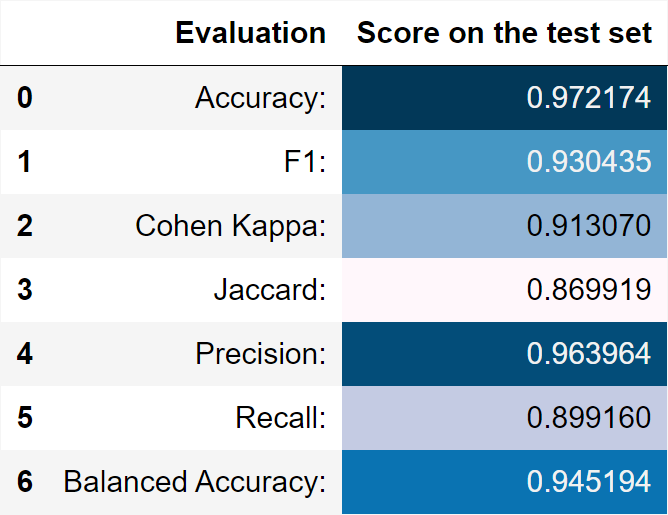

In [ ]:
#################################
####### Confusion matrix ########
#################################
cm = confusion_matrix(y_test, Y_hat_test)
fig, ax = plt.subplots()
sns.heatmap(cm, ax = ax, annot = True, cmap = plt.cm.Reds, fmt = 'd', xticklabels = ['Non-epileptic', 'Epileptic'], yticklabels = ['Non-epileptic', 'Epileptic'])

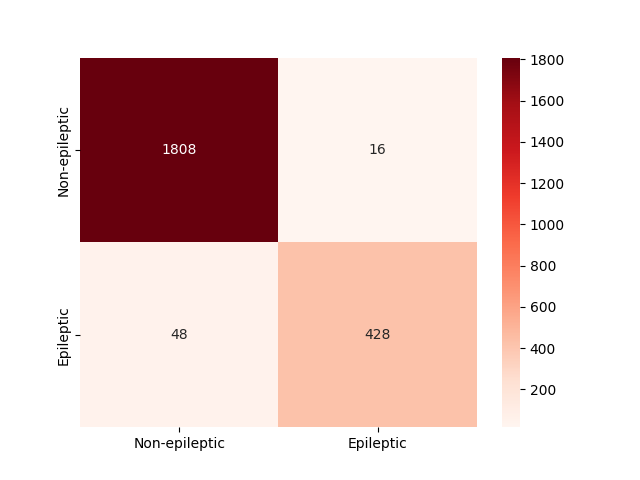

## ❓ PMML creation: example with Neural Network

In [ ]:
###### NEEDS TO DOWNGRADE sklearn TO 1.2.2!! ######


from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
import subprocess


grid_pmml = {
    'hidden_layer_sizes': (100, 100),
    'activation': 'tanh',
    'solver': 'sgd',
    'alpha': 0.0001,
    'max_iter': 1000
}

# preparing
pipeline = PMMLPipeline([("classifier", MLPClassifier(**grid_pmml))])

# training
pipeline.fit(X, y)

# creating .pmml
sklearn2pmml(pipeline, "Server\\pmml\\neural_network.pmml")

# starting Openscoring with .pmml
subprocess.run(["powershell", "java -cp ...Server\\pmml\\neural_network.pmml"], shell=True)       